See https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns; sns.set(font_scale=1.5)

## Example 1: digits (without labels!)

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

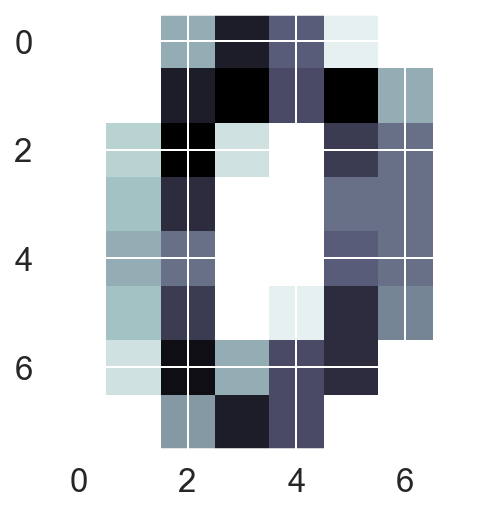

In [3]:
plt.imshow(digits.data[0].reshape(8,8), cmap='bone_r')

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

In [5]:
digits.data.shape

(1797, 64)

Inspecting the centers of the k-means clusters

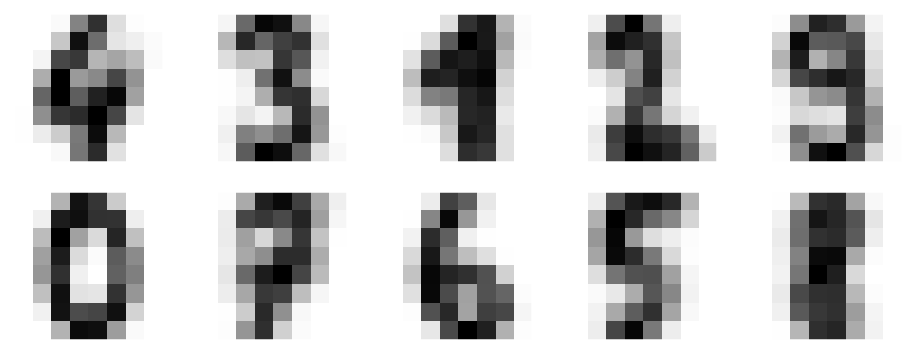

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Finding which k-means label belongs to which digit

In [7]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

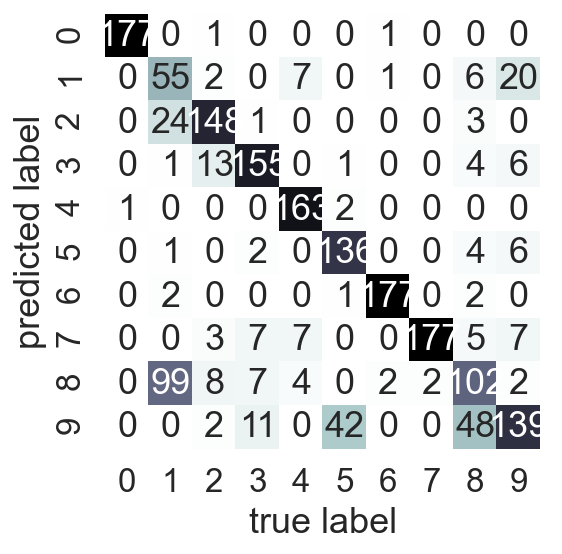

In [9]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names, cmap='bone_r')
plt.xlabel('true label')
plt.ylabel('predicted label');

The accuracy is not amazing, 80%, however still quite good considering this is completely unsupervised!

Pre-processing the data with TSNE enhanced the accuracy greatly!

In [20]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

What about `SpectralClustering`?

In [33]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
                           assign_labels='kmeans')

In [34]:
clusters = model.fit_predict(digits.data)


# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.8230383973288815

Better than just k-means, worse than pre-processed data

### How would it do on the faces?

In [82]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(f'Number of names = {faces.target_names.size}')
print(faces.target_names)
print(faces.images.shape)
print(faces.data.shape)

Number of names = 8
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)
(1348, 2914)


In [83]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
kmeans = KMeans(n_clusters=8, random_state=0)
model = make_pipeline(pca, kmeans)

In [84]:
clusters = model.fit_predict(faces.data)

In [85]:
centers = model['kmeans'].cluster_centers_
centers = model['pca'].inverse_transform(centers)
centers = centers.reshape(8, 62, 47)

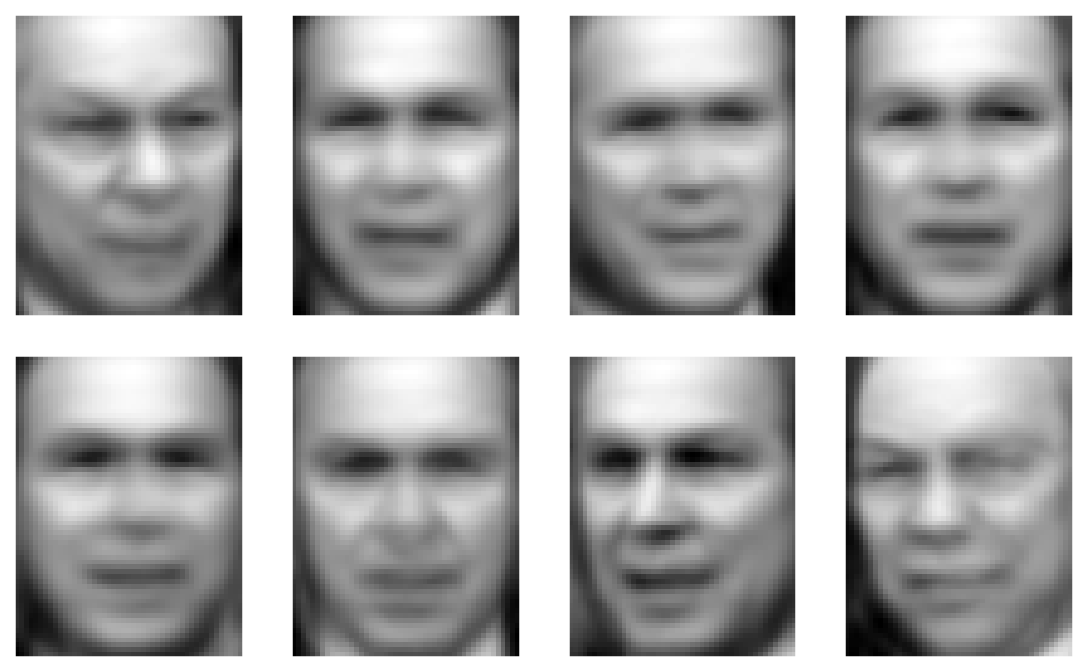

In [86]:
fig, ax = plt.subplots(2, 4, figsize=(8, 5))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary_r)
plt.tight_layout()

Spooky!

In [87]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(8):
    mask = (clusters == i)
    labels[mask] = mode(faces.target[mask])[0]
    print(mode(faces.target[mask])[0],
          np.unique(faces.target[mask], return_counts=True))

[1] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 7, 33,  3, 11,  3,  2,  5,  6]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 19,  50,  37, 161,  33,  22,  33,  47]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 3, 15, 20, 52,  7,  5,  2, 11]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 23,  36,  22, 132,   9,  17,  14,  14]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 16,  40,  23, 117,  31,  17,   1,  43]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 5, 19, 11, 34, 13,  2,  2, 10]))
[1] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 1, 23,  5, 23, 10,  4,  2, 13]))
[1] (array([0, 1, 4, 5, 6]), array([ 3, 20,  3,  2,  1]))


Most faces just look like Bush! Looks like k-means picks up the angle of the face rather than the person-specific features

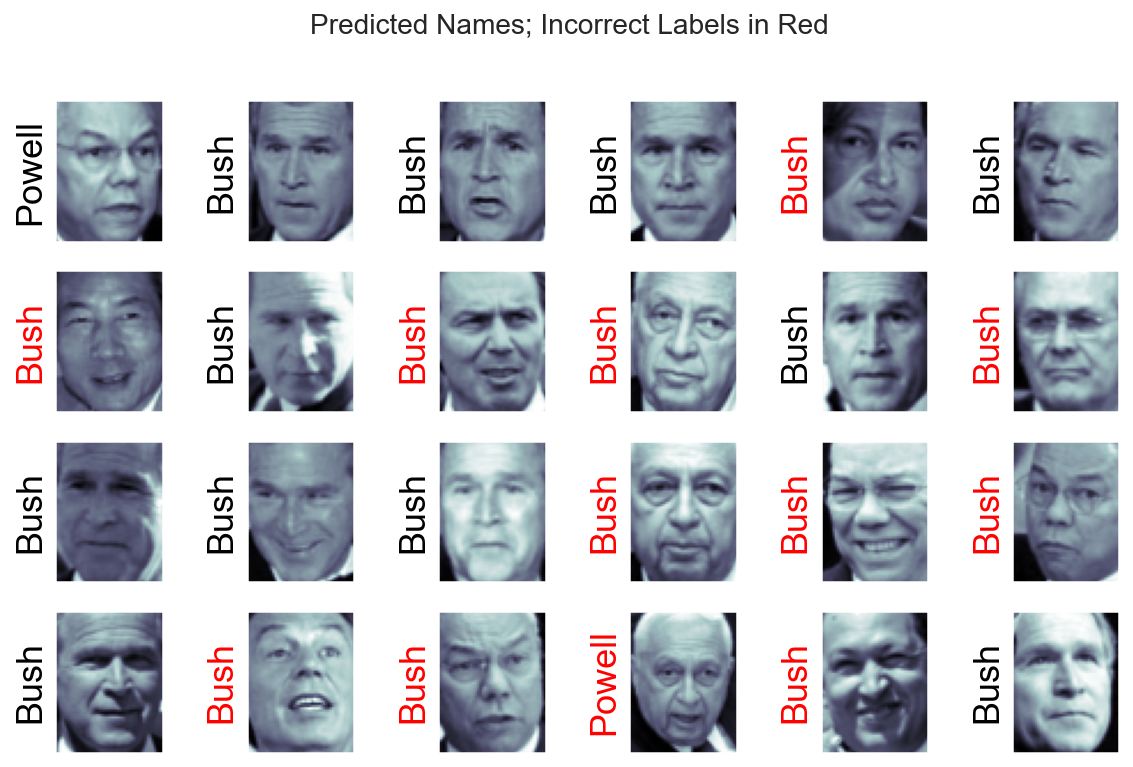

In [88]:
fig, ax = plt.subplots(4, 6, figsize=(10,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.data[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[labels[i]].split()[-1],
                   color='black' if labels[i] == faces.target[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [89]:
print(np.unique(clusters, return_counts=True))
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([ 70, 402, 115, 267, 288,  96,  81,  29]))
(array([1, 3], dtype=int32), array([ 180, 1168]))


In [90]:
from sklearn.metrics import classification_report
print(classification_report(faces.target, labels,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        77
     Colin Powell       0.42      0.32      0.37       236
  Donald Rumsfeld       0.00      0.00      0.00       121
    George W Bush       0.42      0.94      0.58       530
Gerhard Schroeder       0.00      0.00      0.00       109
      Hugo Chavez       0.00      0.00      0.00        71
Junichiro Koizumi       0.00      0.00      0.00        60
       Tony Blair       0.00      0.00      0.00       144

         accuracy                           0.42      1348
        macro avg       0.11      0.16      0.12      1348
     weighted avg       0.24      0.42      0.29      1348



/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


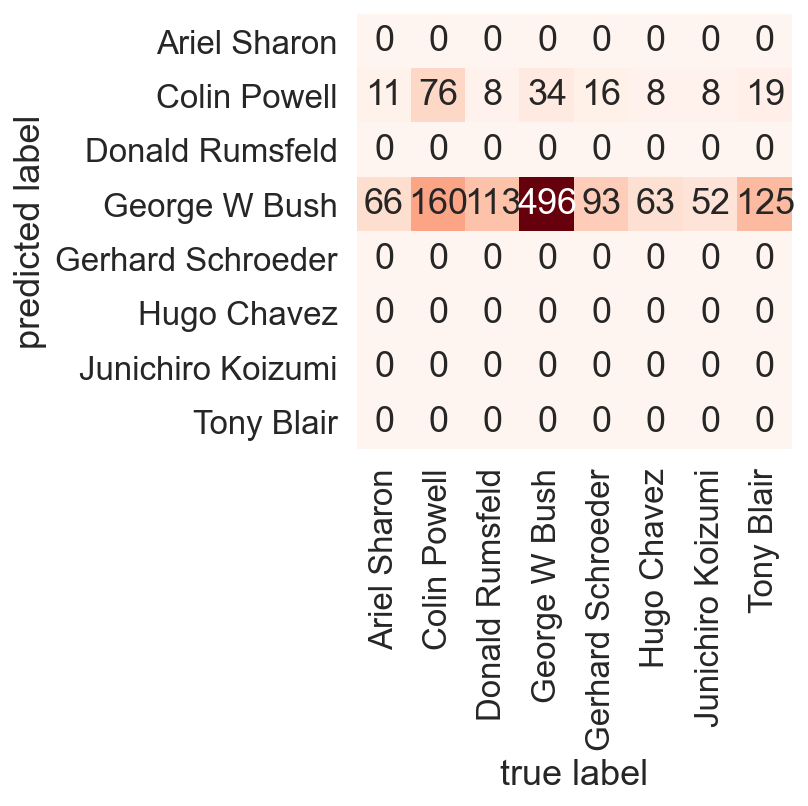

In [91]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(faces.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names, cmap='Reds')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [92]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE



In [94]:
faces_data = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized').fit_transform(faces.data)
faces_data = TSNE(n_components=2, init='random', random_state=0).fit_transform(faces_data)


In [ ]:
clusters = KMeans(n_clusters=8, random_state=0).fit_predict(faces_data)

In [95]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(8):
    mask = (clusters == i)
    labels[mask] = mode(faces.target[mask])[0]
    print(mode(faces.target[mask])[0],
          np.unique(faces.target[mask], return_counts=True))

[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([  8,  54,   9, 104,  18,   8,   2,  27]))
[3] (array([0, 1, 2, 3, 4, 5, 7]), array([ 9, 35, 14, 47, 17,  5, 18]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 7, 18, 15, 53,  7,  4, 20, 20]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([12, 30,  8, 39, 22,  7, 10, 13]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([11, 21,  6, 70, 13, 14,  6, 11]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 4, 21, 19, 70, 13, 13,  1, 26]))
[2] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([19, 12, 29, 27, 14,  8,  8, 16]))
[3] (array([0, 1, 2, 3, 4, 5, 6, 7]), array([  7,  45,  21, 120,   5,  12,  13,  13]))


Most faces just look like Bush! Looks like k-means picks up the angle of the face rather than the person-specific features

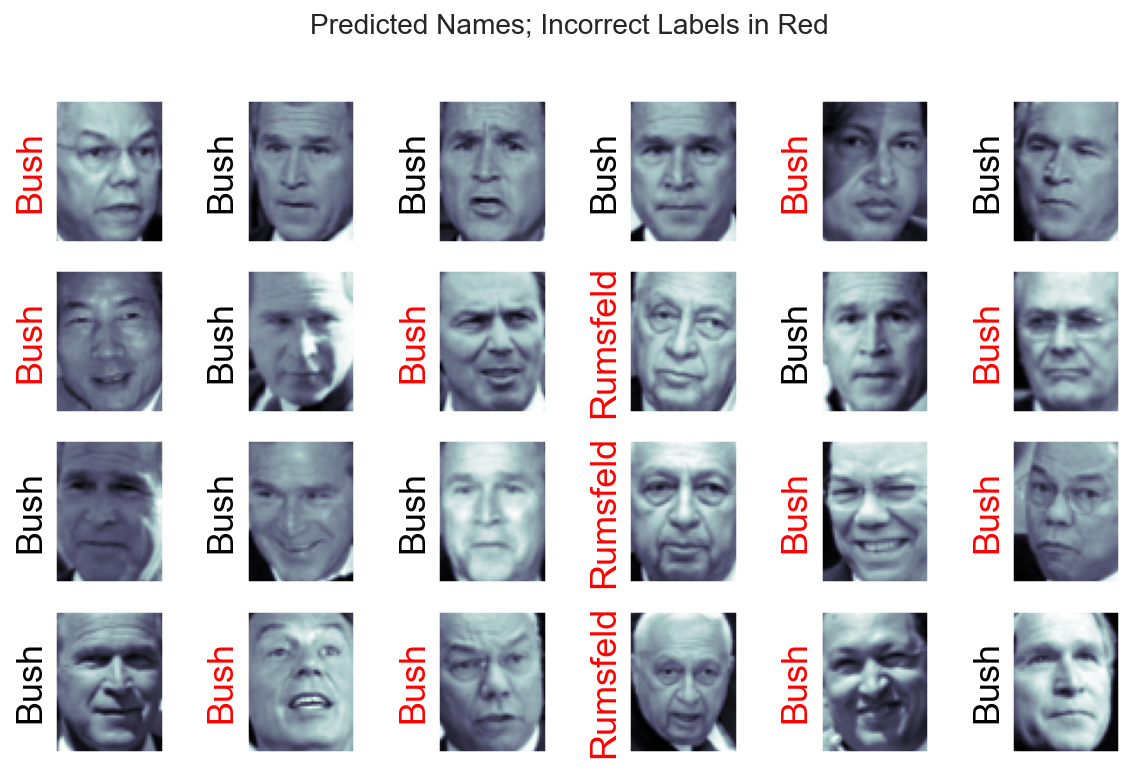

In [96]:
fig, ax = plt.subplots(4, 6, figsize=(10,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.data[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[labels[i]].split()[-1],
                   color='black' if labels[i] == faces.target[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [97]:
print(np.unique(clusters, return_counts=True))
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([230, 145, 144, 141, 152, 167, 133, 236]))
(array([2, 3], dtype=int32), array([ 133, 1215]))


In [98]:
from sklearn.metrics import classification_report
print(classification_report(faces.target, labels,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        77
     Colin Powell       0.00      0.00      0.00       236
  Donald Rumsfeld       0.22      0.24      0.23       121
    George W Bush       0.41      0.95      0.58       530
Gerhard Schroeder       0.00      0.00      0.00       109
      Hugo Chavez       0.00      0.00      0.00        71
Junichiro Koizumi       0.00      0.00      0.00        60
       Tony Blair       0.00      0.00      0.00       144

         accuracy                           0.39      1348
        macro avg       0.08      0.15      0.10      1348
     weighted avg       0.18      0.39      0.25      1348



/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


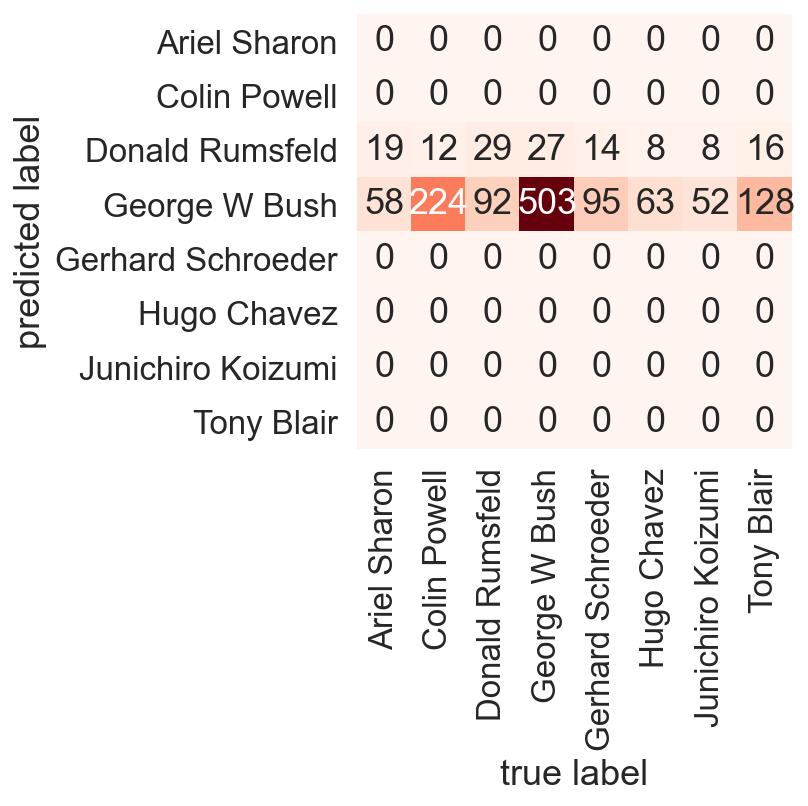

In [99]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(faces.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names, cmap='Reds')
plt.xlabel('true label')
plt.ylabel('predicted label');

Conclusion: k-means is pretty bad on faces!